# Single asperity simulations in 2.5D medium

In this tutorial, we simulate slip on a fault with a single velocity-weakening asperity, embedded in 2.5d medium. 

Within 2.5D approximation, depth-distribution of slip is fixed, exact for case where Posson's ratio is zero (Luo and Ampuero, 2018; Weng and Ampuero, 2019)

We begin by importing some modules.


In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.expanduser("~")
qdyn_dir = os.path.join(base_dir, "qdyn", "qdyn")
plot_dir = os.path.join(qdyn_dir, "utils", "post_processing")

sys.path.append(qdyn_dir)
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

To preprare a simulation, the global simulation and mesh parameters will have to be specified. This is done in three steps: 

1. Specify global parameters, like simulation duration, output resolution, mesh size, and default mesh values
2. Render the mesh (assigning default values to every element)
3. Override the default mesh parameter values to create heterogeneity in the simulation

In this simulation, the only heterogeneity stems from a lateral variation in the direct effect parameter $a$, which is chosen such that the asperity has $(a-b) < 0$, and such that the matrix has $(a - b) > 0$.

In [2]:
###### Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width
LW_ratio = 5                # Fault length to width ratio
asperity_ratio = 5          # Total Length to the asperity length


# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 0         # Periodic fault
set_dict["FAULT_TYPE"] = 1     # Right Lateral Strike Slip Fault
set_dict["TMAX"] = 25*t_yr     # Maximum simulation time [s]
set_dict["NTOUT_OT"] = 10      # Temporal interval (number of time steps) for time series output
set_dict["NTOUT_OX"] = 10     # Temporal interval (number of time steps) for snapshot output
set_dict["NXOUT_OX"] = 2       # Spatial interval (number of elements in x-direction) for snapshot output
set_dict["V_PL"] = 1e-9        # Plate velocity [m/s]
set_dict["MU"] = 3e10          # Shear modulus [Pa]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.9e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"] * 0.99    # Initial velocity [s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])

# Nucleation length [m]
Lc = Lb / cab_ratio

# # Width of asperity [m]
W = Lc * LW_ratio
set_dict["W"] = W

# Asperity length [m]
L_asp = W*LW_ratio

# Total length [m]
L = L_asp * asperity_ratio

# # Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))

# # Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Printing out the lengths related to the fault
print('Process zone width:{:.2f}m'.format(Lb))
print('Nucleation length:{:.2f}m'.format(Lc))
print('Aseprity length:{:.2f}m'.format(L_asp))
print('Fault width:{:.2f}m'.format(W))
print('Grid length:{:.2f}m'.format(L/N))
print('N of elements:{:.0f}'.format(N))

# # Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
set_dict["W"] = L

# # Location on the fault (middle) for time series output
set_dict["IC"] = N // 2

# """ Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

# """ Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"] = set_dict["SET_DICT_RSF"]["B"] * (1 + cab_ratio*(1 - 2*np.exp(-(2*x/L_asp)**6)))

# Write input to qdyn.in
p.write_input()

# On Windows 10, set this flag to True 
# (see http://ydluo.github.io/qdyn/getting_started.html#additional-notes-for-windows-10-users)
p.W10_bash = False

Process zone width:12.00m
Nucleation length:60.00m
Aseprity length:1500.00m
Fault width:300.00m
Grid length:0.92m
N of elements:8192


To see the effect of setting a heterogeneous value of a over the mesh, we can plot $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


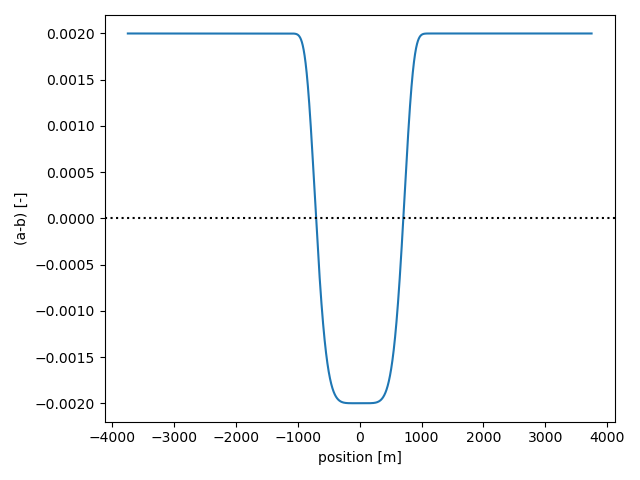

In [3]:
plt.clf()
plt.plot(x, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [m]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
plt.show()

As desired, the asperity is defined by $(a-b) < 0$, embedded in a stable matrix with $(a-b) > 0$.

The `p.write()` command writes a `qdyn.in` file to the current working directory, which is read by QDYN at the start of the simulation. To do this, call `p.run()`. Note that in this notebook, the screen output (`stdout`) is captured by the console, so you won't see any output here.

Also, note that simulations with large number of grid points 'N' may take a few minutes. 

In [4]:
p.run()

True

During the simulation, output is flushed to disk every `NTOUT` time steps. This output can be reloaded without re-running the simulation, so you only have to call `p.run()` again if you made any changes to the input parameters. To read/process the output, call:

In [5]:
p.read_output()

True

For this tutorial, we use a library (`plot_functions.py`) that handles the plotting logistics. This library can be found in the `utils/post_processing` folder in the QDYN directory. To get a general impression of how our fault behaved, we plot the time series of the shear stress $\tau$ and state $\theta$ recorded at the centre of the fault, and the maximum slip rate $v_{max}$ recorded over the entire fault.

<IPython.core.display.Javascript object>


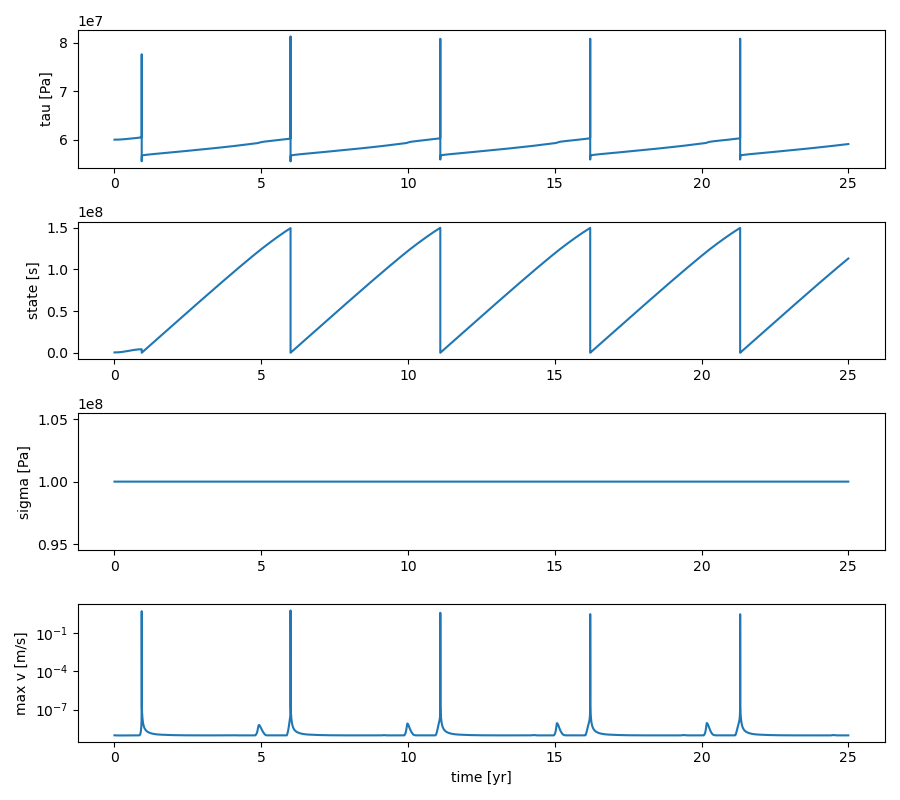

In [6]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

The simulations typically take a few cycles to "warm-up" and to converge to a stable limit cycle. After the warm-up the behaviour of the fault is independent of our choice for initial values. In cases where the fault slip behaviour is chaotic, no stable limit cycle may ever be attained. In our case, a stable limit cycle is attained after about 6 years. To better see what is going on during each cycle, we plot the evolution of the slip rate on the fault from 8 years onwards:

3700


<IPython.core.display.Javascript object>


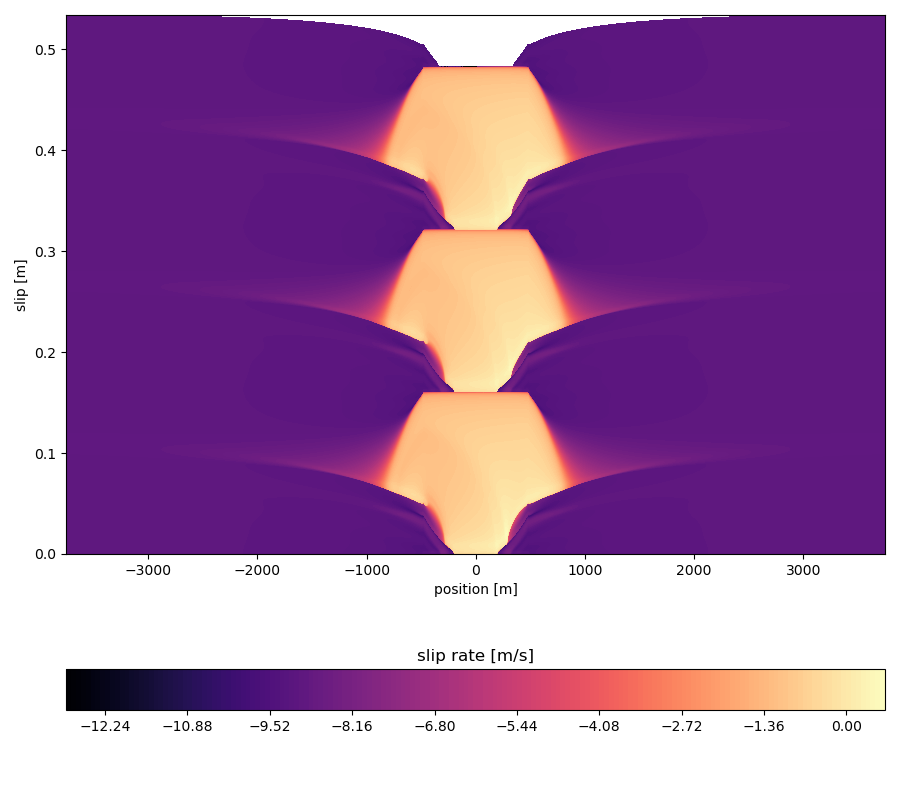

In [7]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=8*t_yr)

In this plot, the warmer colours indicate higher slip rates. The asperity is positioned in the centre of the fault (around $x = 0$). As the fault is progressively loaded, nucleation starts not at the center but at the transition zone where frictional properties changes from velocity weakening to strengthening. Then the the slip propagates along the asperity. You may notice the accumulated slips are relatively close. This indicates a pilse-like slip rather than a crack growth. 

This type of plots is perhaps not immediately intuitive, so lets look at the snapshots in the middle of the asperity. 

<IPython.core.display.Javascript object>


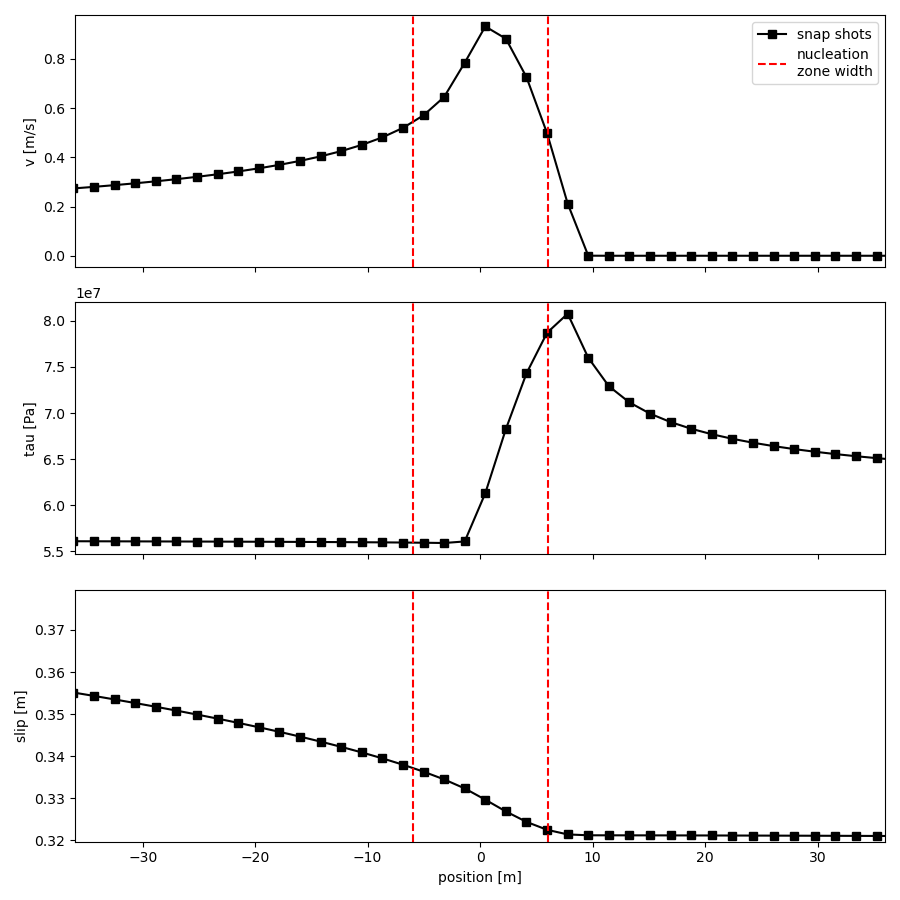

In [10]:
## PLOTTING RUPTURE PROPAGATION AND THE PROCESS ZONE

# Get the pandas dataframe of the snapshot time series.
# The warm up cycle is removed with a condition.
df_ot = p.ot[0][p.ot[0]['t']>8*t_yr] 

# Find the when the time series has the highest slip rate.
ot_step_max = df_ot[df_ot['v']==df_ot['v'].max()]['step'].values[0]

# To match the corresponding step among the outputs get the unique steps
ox_step_unique = p.ox['step'].unique()

# Search the closest step among the snapshots. 
# Since the output intervals are not the same there may have slight time shifts.
ox_step_max = ox_step_unique[np.abs(ox_step_unique - ot_step_max).argmin()]

# The Pandas dataframe corresponds to the highest slip rate.
ox_max = p.ox[p.ox['step']==ox_step_max]


#------- PLOT THE SNAPSHOTS -------#
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex =True, figsize= (9,9))
# slip rate
ax1.plot(ox_max['x'], ox_max['v'], 'k-s', label = 'snap shots')
ax1.axvline(-Lb/2, color = 'r', ls = '--', label = 'nucleation\nzone width')
ax1.axvline(Lb/2, color = 'r', ls = '--')
ax1.set_ylabel('v [m/s]')
# shear stress
ax2.plot(ox_max['x'], ox_max['tau'], 'k-s')
ax2.axvline(-Lb/2, color = 'r', ls = '--')
ax2.axvline(Lb/2, color = 'r', ls = '--')
ax2.set_ylabel('tau [Pa]')
# slip
slip_0 = ox_max.iloc[len(ox_max['slip'])//2]['slip']
ax3.plot(ox_max['x'], ox_max['slip'], 'k-s')
ax3.axvline(-Lb/2, color = 'r', ls = '--')
ax3.axvline(Lb/2, color = 'r', ls = '--')
ax3.set_ylabel('slip [m]')
ax3.set_ylim((slip_0-0.01,slip_0+0.05))

ax1.set_xlim(-3*Lb,3*Lb)
ax3.set_xlabel('position [m]')
ax1.legend(loc=1)
plt.tight_layout()
fig.show()

The squares are the snapshots when the middle of asperity has the highest slip rate and the red dashed lines define the nucleation zone width. Please note that the output is snapshotted in every 2 grid interval.

You may want to look at the slip propagation in more detail with the following animation code. 

In [ ]:
# This will take a minute or two...
qdyn_plot.animation_slip(p.ox, warm_up=8*t_yr)

##### Exercise

Compare the results with the Exercise 2 (Single asperity). In Exercise 2, the width (W) was several times larger than the length.

Now try decrease LW_ratio less than 5 (like 'LW_ratio=2'.) to see how the nucleation of slip and propagation change. 

Also you may check the response for 'LW_ratio=10'. But this setup will require a few minutes. 

In [ ]:
# Clean outputs if necessary.
# [os.remove(x) for x in os.listdir() if x.startswith('output')]